In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np


In [3]:
# Load CIFAR-10 dataset
ds = load_dataset("uoft-cs/cifar10")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
# Define transformation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [5]:
# CIFAR-10 class labels
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [6]:
# Custom Dataset class to apply transformations
class CIFAR10Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["img"]
        label = self.dataset[idx]["label"]
        if self.transform:
            image = self.transform(image)
        return image, label


In [7]:
# Create DataLoaders
train_dataset = CIFAR10Dataset(ds["train"], transform=transform)
test_dataset = CIFAR10Dataset(ds["test"], transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
# Define CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [9]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [11]:
# Train the model
num_epochs = 10
losses = []
train_acc_list = []
test_acc_list = []
iterations = []

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return acc, f1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    train_preds, train_labels = [], []

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

        if (i+1) % 100 == 0:
            iterations.append(len(iterations) + 1)
            losses.append(loss.item())

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_f1 = f1_score(train_labels, train_preds, average='weighted')
    test_acc, test_f1 = evaluate(model, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Train F1: {train_f1:.4f} | Test Acc: {test_acc:.2f}% | Test F1: {test_f1:.4f}")

Epoch 1/10 | Loss: 1.5076 | Train Acc: 44.51% | Train F1: 0.4391 | Test Acc: 57.38% | Test F1: 0.5705
Epoch 2/10 | Loss: 1.1560 | Train Acc: 58.81% | Train F1: 0.5851 | Test Acc: 65.92% | Test F1: 0.6501
Epoch 3/10 | Loss: 0.9746 | Train Acc: 65.51% | Train F1: 0.6533 | Test Acc: 68.34% | Test F1: 0.6834
Epoch 4/10 | Loss: 0.8812 | Train Acc: 69.26% | Train F1: 0.6915 | Test Acc: 73.88% | Test F1: 0.7354
Epoch 5/10 | Loss: 0.8208 | Train Acc: 71.54% | Train F1: 0.7143 | Test Acc: 74.26% | Test F1: 0.7403
Epoch 6/10 | Loss: 0.7097 | Train Acc: 75.44% | Train F1: 0.7538 | Test Acc: 77.95% | Test F1: 0.7769
Epoch 7/10 | Loss: 0.6843 | Train Acc: 76.42% | Train F1: 0.7636 | Test Acc: 78.29% | Test F1: 0.7827
Epoch 8/10 | Loss: 0.6548 | Train Acc: 77.42% | Train F1: 0.7737 | Test Acc: 79.19% | Test F1: 0.7934
Epoch 9/10 | Loss: 0.6281 | Train Acc: 78.12% | Train F1: 0.7808 | Test Acc: 79.94% | Test F1: 0.7984
Epoch 10/10 | Loss: 0.6121 | Train Acc: 78.68% | Train F1: 0.7862 | Test Acc: 78.8

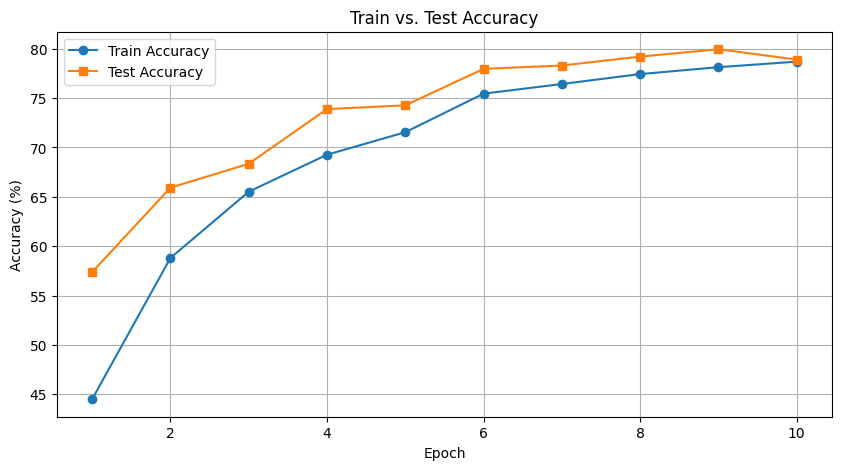

In [12]:
# Plot Train vs. Test Accuracy Curve
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs + 1), train_acc_list, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs + 1), test_acc_list, label="Test Accuracy", marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs. Test Accuracy')
plt.legend()
plt.grid()
plt.show()

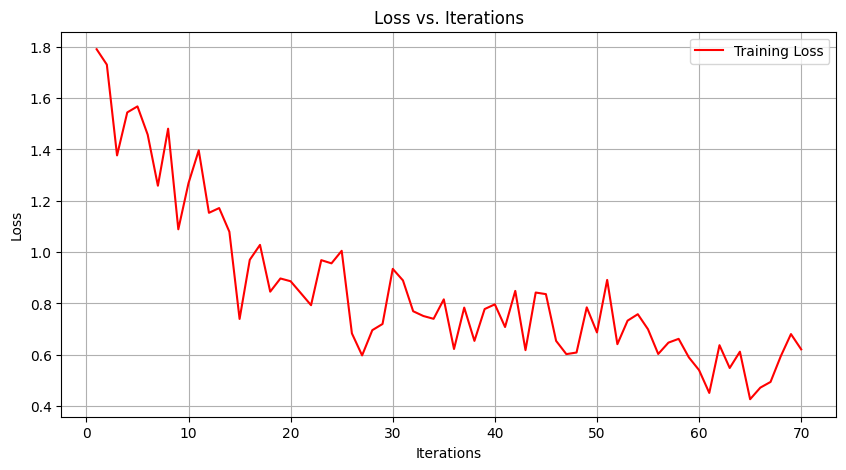

In [13]:
# Plot Loss vs. Iterations
plt.figure(figsize=(10,5))
plt.plot(iterations, losses, label="Training Loss", color='red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()
plt.grid()
plt.show()

In [16]:
# Test the model and display sample predictions
model.eval()
test_preds = []
test_labels = []
sample_images = []
sample_true_labels = []
sample_pred_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

        # Save first few images for sample visualization
        if len(sample_images) < 10:
            sample_images.extend(images[:10].cpu().numpy())
            sample_true_labels.extend(labels[:10].cpu().numpy())
            sample_pred_labels.extend(predicted[:10].cpu().numpy())

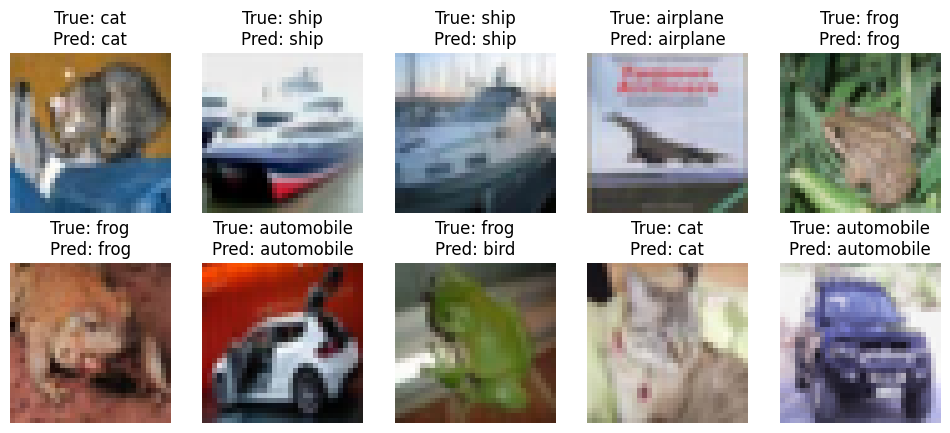

In [21]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, ax in enumerate(axes.flat):
    img = sample_images[i].transpose((1, 2, 0))
    img = (img * 0.5) + 0.5

    ax.imshow(img)
    ax.set_title(f"True: {classes[sample_true_labels[i]]}\nPred: {classes[sample_pred_labels[i]]}")
    ax.axis("off")

plt.show()